## Configuration

In [1]:
# Import packages
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pickle as pkl
from operator import itemgetter
import os
import random
from skimage.transform import resize
from sklearn.metrics import precision_score, recall_score, confusion_matrix, auc, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.layers import Add, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
import time
from tqdm import tqdm
from functools import partial
from PIL import ImageStat, Image

# Processing config
config_test_percent = 0.10
config_validation_perc = 0.2
config_img_height = 180
config_img_width = 180
config_color_mode = "rgb"
config_check_for_duplicates = False
config_n_classes = 5
config_random_state = 2019
config_sample_perc = None

# Augmentation config
config_aug_rotation = 50
config_aug_rescale = 1./255
config_aug_shear_range = 0.0
config_aug_zoom_range = [0.8, 1.2]
config_aug_vert_flip = False
config_aug_horz_flip = True
config_aug_width_shift = 0.2
config_aug_height_shift = 0.2
config_aug_brightness_range = [1, 1]

# Model save & callback config
config_model_timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
config_model_save_name = "D:/indoor_scenes/model_save_dir/mod_scene_img_model_lrs_{dt_tm}.hdf5".format(dt_tm = config_model_timestamp)
config_log_folder = 'D:/indoor_scenes/log_files/'
config_result_log_folder = "D:/indoor_scenes/result_logs/"
config_max_worse_epochs = 20

# Model training config
config_batch_size = 50
config_warmup_epochs = 2
config_cycle_length = 7
#config_min_lr = 0.00001
#config_max_lr = 0.0006
config_min_lr = 0.000025
config_max_lr = 0.0003
config_epochs = 600
config_cnn_activation = 'relu'
config_dense_dropout = 0.1
config_conv_dropout = 0.0
config_l2_reg = 0.000001

# Class file directories
bathroom_dir = "D:/agg_scene_dir/bathroom/"
bedroom_dir = "D:/agg_scene_dir/bedroom/"
diningroom_dir = "D:/agg_scene_dir/diningroom/"
kitchen_dir = "D:/agg_scene_dir/kitchen/"
livingroom_dir = "D:/agg_scene_dir/livingroom/"

# Image configuration dictionary
img_config_dict = {"rotation_range" : config_aug_rotation,
                   "rescale" : config_aug_rescale,
                   "shear_range" : config_aug_shear_range,
                   "zoom_range" : config_aug_zoom_range,
                   "vertical_flip" : config_aug_vert_flip,
                   "horizontal_flip" : config_aug_horz_flip,
                   "width_shift_range" : config_aug_width_shift,
                   "height_shift_range" : config_aug_height_shift,
                   "brightness_range" : config_aug_brightness_range,
                   "validation_perc" : config_validation_perc,
                   "img_h" : config_img_height,
                   "img_w" : config_img_width,
                   "batch_size" : config_batch_size,
                   "warmup_epochs" : config_warmup_epochs,
                   "cycle_length" : config_cycle_length,
                   "min_lr" : config_min_lr,
                   "max_lr" : config_max_lr,
                   "epochs" : config_epochs,
                   "cnn_activation" : config_cnn_activation,
                   "dense_dropout" : config_dense_dropout,
                   "conv_dropout" : config_conv_dropout,
                   "l2_reg" : config_l2_reg,
                   "color_mode" : config_color_mode,
                   "model_timestamp" : config_model_timestamp,
                   "model_save_name" : config_model_save_name,
                   "log_folder" : config_log_folder,
                   "max_worse_epochs" : config_max_worse_epochs}

C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (

## Data Processing & Misc. Functions

In [2]:
def read_ade_img_only(ade_folder):
    """
    Read image files in <ade_folder> where file names do not contain:
        > 'atr'
        > 'seg'
        > 'parts'
    """
    all_files = os.listdir(ade_folder)
    sub_files = [af for af in all_files if ('atr' not in af) \
                          and ('seg' not in af) \
                          and ('parts' not in af)]
    full_paths = [ade_folder + sf for sf in sub_files]
    return full_paths



def seconds_to_time(sec):
    """convert seconds (integer or float) to time in 'hh:mm:ss' format"""
    if (sec // 3600) == 0:
        HH = '00'
    elif (sec // 3600) < 10:
        HH = '0' + str(int(sec // 3600))
    else:
        HH = str(int(sec // 3600))
    min_raw = (np.float64(sec) - (np.float64(sec // 3600) * 3600)) // 60
    if min_raw < 10:
        MM = '0' + str(int(min_raw))
    else:
        MM = str(int(min_raw))
    sec_raw = (sec - (np.float64(sec // 60) * 60))
    if sec_raw < 10:
        SS = '0' + str(int(sec_raw))
    else:
        SS = str(int(sec_raw))
    return HH + ':' + MM + ':' + SS + ' (hh:mm:ss)'



def sec_to_time_elapsed(end_tm, start_tm, return_time = False):
    """apply seconds_to_time function to start and end times
       * dependency on seconds_to_time() function *"""
    sec_elapsed = (np.float64(end_tm) - np.float64(start_tm))
    if return_time:
        return seconds_to_time(sec_elapsed)
    else:
        print('Execution Time: ' + seconds_to_time(sec_elapsed))



def load_resize_images(full_file_paths, resize_height, resize_width):
    """
    Load images and resize according to function arguments
    Args:
        full_file_paths: list of saved image files
        resize_height: height of resized output images
        resize_width: width of resized output images
    Depdendencies:
        numpy
        skimage.transform.resize
        tensorflow.keras.preprocessing.image.load_img
    Returns:
        numpy array of resized images
    """
    read_images = [load_img(c) for c in full_file_paths]
    resized_images = [resize(np.array(ri), (resize_height, resize_width)) for ri in read_images]
    return np.array(resized_images)



def img_add_flip(arr, flip_horiz = True, flip_vert = False):
    """
    Flip numpy array horizontally and/or vertically
    Args:
        arr: three dimensional numpy array
        flip_horiz: flip image horizontally
        flip_vert: flip image vertically
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    arr_copy = arr.copy()
    if flip_horiz:
        arr_copy = np.fliplr(arr_copy)
    if flip_vert:
        arr_copy = np.flipud(arr_copy)
    return arr_copy
    


def img_add_random_noise(arr, noise_perc = 0.05):
    """
    Randomly change <noise_perc> % of pixels in an image
    Args:
        arr: three dimensional numpy array
        noise_perc: percentage of values to replace    
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    arr_copy = arr.copy()
    noise = np.random.randint(0, 255, size = arr.shape)
    rand_numbers = random.sample(range(100), int(noise_perc * 100))
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                if random.choice(range(100)) in rand_numbers:
                    arr_copy[x][y][z] += noise[x][y][z]
    return arr_copy
                


def img_add_stripe_noise(arr, stripe_perc = 0.05, stripe_direction = 'h'):
    """
    Add horizontal stripe of randomly colored pixels within a 3d numpy array
    Args:
        arr: three dimensional numpy array
        stripe_perc: height or width of noise stripe (percentage of array dimension)
        stripe_direction: the direction of the noise strip (horizonal or vertical)
    """
    assert len(arr.shape) == 3, "'arr' input array must be three dimensional"
    assert stripe_direction in ['h', 'v'], "'stripe_direction' parameter must be 'v' or 'h'"
    arr_copy = arr.copy()
    noise = np.random.randint(0, 255, size = arr.shape)
    if stripe_direction == 'h':
        use_dim = 0
    else:
        use_dim = 1
    
    # Stripe position
    pixel_length = int(stripe_perc * arr.shape[use_dim])
    stripe_start = random.choice(range(arr.shape[use_dim] - pixel_length))
    stripe_end = stripe_start + pixel_length
    stripe_range = range(stripe_start, stripe_end)
    
    # Value replacement
    for x in range(arr.shape[0]):
        for y in range(arr.shape[1]):
            for z in range(arr.shape[2]):
                if stripe_direction == 'h':
                    if x in stripe_range:
                        arr_copy[x][y][z] += noise[x][y][z]
                else:
                    if y in stripe_range:
                        arr_copy[x][y][z] += noise[x][y][z]
    return arr_copy



def describe_img_sizes(list_of_arrays):
    """
    Describe distribution of array shapes for a list of 3d arrays
    Args:
        list_of_arrays: list of 3d numpy arrays
    Dependencies:
        numpy (import as np)
        pandas (import as pd)
    Returns:
        pandas DataFrame
    """    
    # Dimensions of each array
    img_ht = [a.shape[0] for a in list_of_arrays]
    img_wd = [a.shape[1] for a in list_of_arrays]
    img_d = [a.shape[2] for a in list_of_arrays]
    img_hwd = [a.shape for a in list_of_arrays]
    
    # Mean, median, mode of each single measure
    mean_size = [np.mean(x) for x in [img_ht, img_wd, img_d]]
    median_size = [np.median(x) for x in [img_ht, img_wd, img_d]]
    modal_size = [max(x, key = x.count) for x in [img_ht, img_wd, img_d]]
    
    # Output summary statistics and print most common dimension
    output_df = pd.DataFrame({'dimension': ['height', 'width', 'depth'],
                              'mean' : mean_size,
                              'median' : median_size,
                              'mode' : modal_size})
    
    modal_arr_shape = max(img_hwd, key = img_hwd.count)
    modal_freq = img_hwd.count(modal_arr_shape)
    modal_perc_freq = round(modal_freq / len(img_hwd) * 100, 1)
    print_msg = "The most common array shape is {a} with a frequency of {b} ({c}%)".\
    format(a = str(modal_arr_shape),
           b = str(int(modal_freq)),
           c = str(modal_perc_freq))
    print(print_msg)
    return output_df

    

def demo_data_generator(generator_class):
    """
    Look at 20 examples of images produced by Keras ImageDataGenerator
    Args:
        generator_class: ImageDataGenerator.flow_from_dataframe object
    Dependencies:
        Keras
        matplotlib.pyplot as plt
    """
    plt.figure(figsize=(12, 12))
    for i in range(0, 20):
        plt.subplot(5, 4, i+1)
        for x, y in generator_class:
            plt.imshow(x[0])
            break
    plt.tight_layout()
    plt.show()
        


def shuffle_two_lists(list_a, list_b):
    """
    Randomly shuffle two lists with the same order, return numpy arrays
    Args:
        list_a: first list you want to shuffle
        list_b: second list you want to shuffle
    Dependencies:
        numpy (import as np)
        operator.itemgetter
        random
    """
    assert len(list_a) == len(list_b), "two input lists must have the same length"
    
    # Define inner function
    def index_slice_list(lst, indices):
    # Slice list by list of indices
        list_slice = itemgetter(*indices)(lst)
        if len(indices) == 1:
            return [list_slice]
        else:
            return list(list_slice)
    
    # Randomly shuffle positional indices
    shuffle_indices = [i for i in range(len(list_a))]
    random.shuffle(shuffle_indices)
    
    # Reorder and return lists
    a_shuffled = index_slice_list(lst = list_a, indices = shuffle_indices)
    b_shuffled = index_slice_list(lst = list_b, indices = shuffle_indices)
    return a_shuffled, b_shuffled



def make_class_weight_dict(train_y_labels, return_dict = False):
    """
    Return dictionary of inverse class weights for imbalanced response
    Args:
        train_y_labels: training set response variable (list)
        return_dict: if True, return dictionary of classes & weights..else return list of classes and list of weights
    """
    train_class_counts = dict((x,train_y_labels.count(x)) for x in set(train_y_labels))
    max_class = max(train_class_counts.values())
    class_weights = [max_class / x for x in train_class_counts.values()]
    class_weight_dict = dict(zip([i for i in train_class_counts.keys()], class_weights))
    if return_dict:
        return class_weight_dict
    else:
        return list(class_weight_dict.keys()), list(class_weight_dict.values())

## Duplicate Image File Check/Removal Functions

In [3]:
def unnest_list_of_lists(LOL):
    """Unnest list of lists"""
    import itertools
    return list(itertools.chain.from_iterable(LOL))



def img_to_hash(img_path, new_size = (20,20)):
    """
    *** inspired by Vladislav Zorov ***
    Create approximate unique hash for a resized image
    Args:
        img_path: path to image file
        new_size: tuple of width and height dimensions of resized image
    """
    img_obj = Image.open(img_path).resize(new_size, Image.LANCZOS).convert(mode="L")
    img_mean = ImageStat.Stat(img_obj).mean[0]
    return sum((1 if j > img_mean else 0) << i for i, j in enumerate(img_obj.getdata()))



def index_slice_list(lst, indices):
    """Slice list by list of indices"""
    from operator import itemgetter
    list_slice = itemgetter(*indices)(lst)
    if len(indices) == 1:
        return [list_slice]
    else:
        return list(list_slice)


    
def lst_dupl_indices(lst):
    """Returns indices of list with duplicated elements"""
    output_list = []
    for i, x in enumerate(lst):
        if len([j for j in range(len(lst)) if lst[j] == x]) > 1:
            output_list.append(i)
    return output_list



def find_duplicate_images(path_list, delete_duplicates = False):
    """
    Using approximate hashing for image files, identify/delete duplicate images
    Args:
        path_list: list of paths to image files
        delete_duplicates: if True, delete duplicate files from system otherwise print count
    """
    all_path_hash = [img_to_hash(x) for x in tqdm(path_list)]
    dupl_path_indices = lst_dupl_indices(all_path_hash)
    if len(dupl_path_indices) == 0:
        print("\n\nNo duplicate images found")
    else:
        dupl_df = pd.DataFrame({'path' : path_list, 'hash' : all_path_hash}).iloc[dupl_path_indices]
        keep_list = []
        remove_list = []
        unique_hash = set(dupl_df['hash'])
        for i, x in enumerate(unique_hash):
            same_files = list(set(dupl_df[dupl_df.hash == x]['path']))
            keep_list.append(same_files[0])
            for f in same_files[1:]:
                remove_list.append(f)
        if delete_duplicates:
            print("\n\nDeleting {n} duplicate image files".format(n = str(int(len(remove_list)))))
            for rl in remove_list:
                os.remove(rl)
        else:
            print("\n\n{n} duplicate image files found".format(n = str(int(len(remove_list)))))

## Model Fitting Functions / Classes

In [4]:
def get_number_gpu():
    """
    Return number of available GPUs
    Dependencies:
        from tensorflow.python.client import device_lib
    """
    n_gpu = len([x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU'])
    return n_gpu

In [5]:
def tensorboard_launch_how_to(tb_log_dir):
    """Instructions to launch tensorboard from Windows command prompt"""
    header_str = "To launch tensorboard, do the following in command prompt:\n\n"
    cmd_cd = "     > cd {m}".format(m = tb_log_dir) + "\n\n"
    cmd_launch = "     > tensorboard --logdir=./ --host localhost --port 8088" + "\n\n"
    brows = "Go to:\n" + "http://localhost:8088"
    print(header_str + cmd_cd + cmd_launch + brows)

In [6]:
class CyclicalRateSchedule:
    """
    Return a list of cyclical learning rates with the first <warmup_epochs> using minimum value
    Args:
        min_lr: minimum learning rate in cycle and learning rate during the first <warmup_epochs> epochs
        max_lr: maximum learning rate in cycle
        warmup_epochs: the number of initial epochs for which to run the minimum learning rate
        cycle_length: the number of epochs between min and max learning rates
        n_epochs: number of epochs for which to generate a learning rate
        logarithmic: if true, increase rates logarithmically (rather than linearly) during cycle
    """
    def __init__(self, min_lr = 0.00001, max_lr = 0.0006, warmup_epochs = 5,
                 cycle_length = 10, n_epochs = 100, logarithmic = False):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.cycle_length = cycle_length
        self.n_epochs = n_epochs
        self.logarithmic = logarithmic
    
    def get_rates(self):
        warmup_rates = [self.min_lr] * self.warmup_epochs
        cycle_delta = (self.max_lr - self.min_lr) / self.cycle_length
        n_cycles = int(np.ceil(self.n_epochs / self.cycle_length))
        if self.logarithmic:
            cycle_rates = list(np.logspace(np.log10(self.min_lr), np.log10(self.max_lr), num = self.cycle_length)) * n_cycles
        else:
            cycle_rates = [self.min_lr + (i * cycle_delta) for i in range(self.cycle_length)] * n_cycles
        all_rates = warmup_rates + cycle_rates
        return all_rates
    
    def plot_cycle(self, first_n = None):
        rates = self.get_rates()
        if first_n is not None:
            show_n = rates[0:first_n]
        else:
            show_n = rates
        plt.plot(show_n)
        plt.show()
        
    def lr_scheduler(self):
        rates = self.get_rates()
        def schedule(epoch):
            return rates[epoch]
        return LearningRateScheduler(schedule, verbose = 1)

In [7]:
def resnet_conv2d(input_x, filter_size = [64, 64, 256], kernel_size = (3,3), activation = 'relu'):
    # Layer 1
    x = Conv2D(filters = filter_size[0], kernel_size = (1,1), strides = (2,2), kernel_initializer='he_normal')(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Layer 2
    x = Conv2D(filters = filter_size[1], kernel_size = kernel_size, padding = "same", kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Layer 3
    x = Conv2D(filters = filter_size[2], kernel_size = (1,1), strides = (1,1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Skip layer
    shortcut = Conv2D(filters = filter_size[2], kernel_size = (1, 1), strides = (2,2), kernel_initializer='he_normal')(input_x)
    shortcut = BatchNormalization()(shortcut)
    x = Add()([x,shortcut])
    x = Activation(activation)(x)
    return x

def resnet_conv_10_layer(kernel_size = (3,3), img_height = config_img_height,
                         img_width = config_img_width, color_mode = config_color_mode, 
                         activ = config_cnn_activation, n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)
    
    # Initial convolutional layer
    x = Conv2D(filters = 32, kernel_size = (4,4), strides = (2,2), padding = "same")(x_input)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    
    # Resnet layers
    x = resnet_conv2d(x, filter_size = [32, 32, 64])
    x = resnet_conv2d(x, filter_size = [32, 32, 64])
    x = resnet_conv2d(x, filter_size = [32, 32, 64])
    
    x = resnet_conv2d(x, filter_size = [64, 64, 128])
    x = resnet_conv2d(x, filter_size = [64, 64, 128])
    x = resnet_conv2d(x, filter_size = [64, 64, 128])
    
    x = resnet_conv2d(x, filter_size = [128, 128, 256])
    x = resnet_conv2d(x, filter_size = [128, 128, 256])
    x = resnet_conv2d(x, filter_size = [128, 128, 256])
    
    x = resnet_conv2d(x, filter_size = [128, 128, 256])
    x = resnet_conv2d(x, filter_size = [128, 128, 256])
    x = resnet_conv2d(x, filter_size = [128, 128, 256])
    
    x = resnet_conv2d(x, filter_size = [256, 256, 512])
    x = resnet_conv2d(x, filter_size = [256, 256, 512])
    x = resnet_conv2d(x, filter_size = [256, 256, 512])
    
    # Dimension reduction before flattening
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x)    

    # Feed forward and output layers
    x = Flatten()(x)   
    x = Dense(n_classes, activation = 'softmax')(x)
    
    # Model object
    model = Model(inputs = x_input, outputs = x, name = 'resnet_ten_layer_model')
    return model

In [8]:
def triple_conv2d(input_x, filter_size, kernel_size, l2_reg, dropout, activation):
    
    # Layer 1
    x = Conv2D(filters = filter_size, kernel_size = kernel_size,
               kernel_regularizer = l2(l2_reg), strides = (2,2), padding = "same")(input_x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Layer 2
    x = Conv2D(filters = filter_size, kernel_size = kernel_size,
               kernel_regularizer = l2(l2_reg), strides = (1,1), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    
    # Layer 3
    x = Conv2D(filters = filter_size, kernel_size = kernel_size,
               kernel_regularizer = l2(l2_reg), strides = (1,1), padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(config_conv_dropout)(x)
    
    return x

In [9]:
def conv_10_layer(dense_dropout = config_dense_dropout, conv_dropout = config_conv_dropout,
                  l2_reg = config_l2_reg, kernel_size = (3,3), img_height = config_img_height,
                  img_width = config_img_width, color_mode = config_color_mode, activ = config_cnn_activation,
                  n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)
    
    # Initial convolutional layer
    x = Conv2D(filters = 64, kernel_size = (8,8), padding = "same")(x_input)
    x = BatchNormalization()(x)
    x = Activation(activ)(x)
    
    # Triple convolutional layers
    x = triple_conv2d(x, filter_size = 64, kernel_size = (3,3), l2_reg = l2_reg, dropout = conv_dropout, activation = activ)
    x = triple_conv2d(x, filter_size = 128, kernel_size = (3,3), l2_reg = l2_reg, dropout = conv_dropout, activation = activ)
    x = triple_conv2d(x, filter_size = 256, kernel_size = (3,3), l2_reg = l2_reg, dropout = conv_dropout, activation = activ)
    
    # Dense Layers
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation(activ)(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(128)(x)
    x = Activation(activ)(x)
    x = Dropout(dense_dropout)(x)
    x = Dense(64)(x)
    x = Activation(activ)(x)
    x = Dense(n_classes, activation = "softmax")(x)
    
    # Model object
    model = Model(inputs = x_input, outputs = x, name = 'conv_10_layer') 
    return model

In [10]:
def rn_id_block(input_x, kernel_size, filters):
    """
    Residual Network Identity Block
        Three-layer block where the shortcut (input) does not have a convolutional layer applied to it
    Args:
        input_x: tensor input
        kernel_size: size of convolutional kernel (integer)
        filters: list of three filter sizes to use in layer block
    Returns:
        tensor
    """
    # Layer 1
    x = Conv2D(filters[0], (1, 1), kernel_initializer='he_normal')(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 2
    x = Conv2D(filters[1], kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 3
    x = Conv2D(filters[2], (1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    # Skip Connection
    x = Add()([x, input_x])
    x = Activation('relu')(x)
    return x

def rn_conv_block(input_x, kernel_size, filters, strides=(2, 2)):
    """
    Residual Network Convolutional Block
        Three-layer block where the shortcut (input) has a convolutional layer applied to it
    Args:
        input_x: tensor input
        kernel_size: size of convolutional kernel (integer)
        filters: list of three filter sizes to use in layer block
    Returns:
        tensor
    """
    # Layer 1
    x = Conv2D(filters[0], (1, 1), strides=strides, kernel_initializer='he_normal')(input_x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Layer 2
    x = Conv2D(filters[1], kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Layer 3
    x = Conv2D(filters[2], (1, 1), kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)

    # Skip Connection
    shortcut = Conv2D(filters[2], (1, 1), strides=strides, kernel_initializer='he_normal')(input_x)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x



def resnet_conv_28_layer(kernel_size = (3,3), img_height = config_img_height,
                         img_width = config_img_width, color_mode = config_color_mode, 
                         activ = config_cnn_activation, n_classes = config_n_classes):
    """Resnet with 28 convolutional layers"""
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)

    # Layer 1
    x = ZeroPadding2D(padding=(3, 3))(x_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Block 1
    x = rn_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = rn_id_block(x, 3, [64, 64, 256])

    # Block 2
    x = rn_conv_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])

    # Block 3
    x = rn_conv_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])

    # Block 4
    x = rn_conv_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])

    # Dimension Reduction
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x) 
    x = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs = x_input, outputs = x, name = 'resnet_50_layer') 
    return model



def resnet_conv_28_layer_small(kernel_size = (3,3), img_height = config_img_height,
                               img_width = config_img_width, color_mode = config_color_mode, 
                               activ = config_cnn_activation, n_classes = config_n_classes):
    """Resnet with 28 convolutional layers"""
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)

    # Layer 1
    x = ZeroPadding2D(padding=(3, 3))(x_input)
    x = Conv2D(32, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # Block 1
    x = rn_conv_block(x, 3, [32, 32, 128], strides=(1, 1))
    x = rn_id_block(x, 3, [32, 32, 128])

    # Block 2
    x = rn_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = rn_id_block(x, 3, [64, 64, 256])

    # Block 3
    x = rn_conv_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])

    # Block 4
    x = rn_conv_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])

    # Dimension Reduction
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x) 
    x = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs = x_input, outputs = x, name = 'resnet_50_layer') 
    return model



def resnet_conv_50_layer(kernel_size = (3,3), img_height = config_img_height,
                         img_width = config_img_width, color_mode = config_color_mode, 
                         activ = config_cnn_activation, n_classes = config_n_classes):
    # Input shape
    if color_mode == "rgb":
        config_input_shape = (config_img_height, config_img_width, 3)
    else:
        config_input_shape = (config_img_height, config_img_width, 1)
        
    x_input = Input(config_input_shape)

    # Layer 1
    x = ZeroPadding2D(padding=(3, 3))(x_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D(padding=(1, 1))(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Block 1
    x = rn_conv_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = rn_id_block(x, 3, [64, 64, 256])
    x = rn_id_block(x, 3, [64, 64, 256])

    # Block 2
    x = rn_conv_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])
    x = rn_id_block(x, 3, [128, 128, 512])

    # Block 3
    x = rn_conv_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])
    x = rn_id_block(x, 3, [256, 256, 1024])

    # Block 4
    x = rn_conv_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])
    x = rn_id_block(x, 3, [512, 512, 2048])

    # Dimension Reduction
    x = GlobalAvgPool2D(name = 'global_avg_pooling')(x) 
    x = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs = x_input, outputs = x, name = 'resnet_50_layer') 

    return model

## Evaluation Functions

In [11]:
def multiclass_acc_eval(class_list, pred_probs, test_y):
    """
    Evaluate sensitivity, specificity, and accuracy for numpy array of predicted probabilities
    Args:
        class_list: list of classes being predicted (strings)
        pred_probs: numpy array of class probabilities corresponding to test set
        test_y: list of categorical classes corresponding to test set (strings)
    """
    # Create lists of predicted probabilities and actual classes
    sorted_class_list = list(np.sort(class_list))
    eval_df_list = []
    for cl in sorted_class_list:
        class_binary = [1 if x == cl else 0 for x in test_y]
        class_probs = list(pred_probs[:, sorted_class_list.index(cl)])
        class_bin_probs = [np.round(x) for x in class_probs]
        tn, fp, fn, tp = confusion_matrix(class_binary, class_bin_probs).ravel()
        tc = tn + fp + fn + tp
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        acc = (tp + tn) / tc
        auc = roc_auc_score(class_binary, class_probs)
        class_df = pd.DataFrame({'class':cl, 'true_pos':tp, 'true_neg':tn, 'false_pos':fp,
                                 'false_neg':fn, 'total_count':tc, 'true_positive_rate':tpr,
                                 'true_negative_rate':tnr, 'accuracy':acc, 'auc':auc}, index = [0])
        eval_df_list.append(class_df)
    eval_df = pd.concat(eval_df_list, ignore_index = True)
    return eval_df
    

    
def plot_random_test_pred(test_y_list, pred_arr, class_list, img_arr):
    """
    Plot random image and its predicted values for  each class
    Args:
        test_y_list: list of response values being predicted
        pred_arr: predicted probability array
        class_list: list of classes in column-wise order of <pred_arr>
        img_arr: array from which to sample image
    Dependencies:
        random, numpy, matplotlib.pyplot
    """
    random_index = random.choice(range(len(test_y_list)))
    actual_str = "Actual: {k}\n".format(k = test_y_list[random_index])
    pred_str = "\n".join([class_list[i] + ": " + \
                          str(round(pred_arr[random_index,i] * 100,3)) + "%" \
                          for i in range(len(class_list))])
    plt.imshow(img_arr[random_index])
    plt.title(actual_str + pred_str)
    
def plot_training_progress(csv_file_path, train_metric, validation_metric,
                           train_color = 'blue', validation_color = 'orange'):
    """
    Plot training progress using Keras csv logger as input
    Args:
        csv_file_path: path to csv created by keras.callbacks.CSVLogger
        train_metric: name of column used for training evaluation (e.g. 'acc')
        validation_metric: name of column used for validation evaluation (e.g. 'val_acc')
    """
    train_progress_df = pd.read_csv(csv_file_path)
    plt.plot('epoch', train_metric, data = train_progress_df, marker='o',
             markerfacecolor=train_color, color=train_color, label = train_metric)
    plt.plot('epoch', validation_metric, data = train_progress_df, marker='o',
             markerfacecolor=validation_color, color=validation_color, label = validation_metric)
    plt.legend()

## Data Processing Functions

In [12]:
def scene_img_paths(br_dir = bathroom_dir, bd_dir = bedroom_dir,
                    dr_dir = diningroom_dir, kch_dir = kitchen_dir,
                    lr_dir = livingroom_dir,
                    check_for_duplicates = config_check_for_duplicates,
                    test_perc = config_test_percent,
                    random_state = config_random_state):
    
    # File Paths
    br_paths = [br_dir + fp for fp in os.listdir(br_dir)]
    bd_paths = [bd_dir + fp for fp in os.listdir(bd_dir)]
    dr_paths = [dr_dir + fp for fp in os.listdir(dr_dir)]
    kch_paths = [kch_dir + fp for fp in os.listdir(kch_dir)]
    lr_paths = [lr_dir + fp for fp in os.listdir(lr_dir)]
    all_paths = br_paths + bd_paths + dr_paths + kch_paths + lr_paths
    
    # Check for Duplicates
    if config_check_for_duplicates:
        find_duplicate_images(all_paths, delete_duplicates = True)
        
    # Train / test split
    train_br, test_br = train_test_split(br_paths, test_size = test_perc, random_state = random_state)
    train_bd, test_bd = train_test_split(bd_paths, test_size = test_perc, random_state = random_state)
    train_dr, test_dr = train_test_split(dr_paths, test_size = test_perc, random_state = random_state)
    train_kch, test_kch = train_test_split(kch_paths, test_size = test_perc, random_state = random_state)
    train_lr, test_lr = train_test_split(lr_paths, test_size = test_perc, random_state = random_state)
    agg_train_files = train_br + train_bd + train_dr + train_kch + train_lr
    agg_test_files = test_br + test_bd + test_dr + test_kch + test_lr
    
    # Create training labels
    train_y_br = ['bathroom' for x in range(len(train_br))]
    train_y_bd = ['bedroom' for x in range(len(train_bd))]
    train_y_dr = ['diningroom' for x in range(len(train_dr))]
    train_y_kch = ['kitchen' for x in range(len(train_kch))]
    train_y_lr = ['livingroom' for x in range(len(train_lr))]
    agg_train_y = train_y_br + train_y_bd + train_y_dr + train_y_kch + train_y_lr
    
    # Create test labels
    test_y_br = ['bathroom' for x in range(len(test_br))]
    test_y_bd = ['bedroom' for x in range(len(test_bd))]
    test_y_dr = ['diningroom' for x in range(len(test_dr))]
    test_y_kch = ['kitchen' for x in range(len(test_kch))]
    test_y_lr = ['livingroom' for x in range(len(test_lr))]
    agg_test_y = test_y_br + test_y_bd + test_y_dr + test_y_kch + test_y_lr
    
    # Create class weights
    class_list, class_weights = make_class_weight_dict(agg_train_y, return_dict = False)
    
    return agg_train_files, agg_test_files, agg_train_y, agg_test_y, class_list, class_weights

In [13]:
def make_generators(train_x, train_y, test_x, test_y, class_list,
                    aug_dict = img_config_dict, sample_perc = config_sample_perc):
    """
    Make train, validation, and test set generators
    Returns:
        train generator
        validation generator
        test generator
        number of training observations
        number of validation observations
    """
    
    # Target size
    target_size = (aug_dict.get("img_h"), aug_dict.get("img_w"))
    
    # Generator dataframes to be fed into batch processing
    train_gen_df = pd.DataFrame({'file_name':  train_x, 'category' : train_y})
    if sample_perc is not None:
        sample_n = int(sample_perc * train_gen_df.shape[0])
        train_gen_df = train_gen_df.sample(sample_n)
    train_gen_df, valid_gen_df = train_test_split(train_gen_df, test_size = aug_dict.get("validation_perc"))
    test_gen_df = pd.DataFrame({'file_name':  test_x, 'category' : test_y})
    
    
    # Generator class objects
    train_gen = ImageDataGenerator(rotation_range = aug_dict.get("rotation_range"),
                                   rescale = aug_dict.get("rescale"),
                                   shear_range = aug_dict.get("shear_range"),
                                   zoom_range = aug_dict.get("zoom_range"),
                                   vertical_flip = aug_dict.get("vertical_flip"),
                                   horizontal_flip = aug_dict.get("horizontal_flip"),
                                   width_shift_range = aug_dict.get("width_shift_range"),
                                   height_shift_range = aug_dict.get("height_shift_range"),
                                   brightness_range = aug_dict.get("brightness_range"))

    valid_gen = ImageDataGenerator(rescale = aug_dict.get("rescale"))
    
    # Link image augmentation class objects with file dataframes
    train_generator = train_gen.flow_from_dataframe(train_gen_df,  
                                                    x_col = "file_name", 
                                                    y_col = "category",
                                                    target_size = target_size,
                                                    class_mode = "categorical",
                                                    shuffle = True,
                                                    batch_size = aug_dict.get("batch_size"),
                                                    classes = class_list,
                                                    color_mode = aug_dict.get("color_mode"))

    valid_generator = valid_gen.flow_from_dataframe(valid_gen_df,  
                                                    x_col = "file_name", 
                                                    y_col = "category",
                                                    target_size = target_size,
                                                    class_mode = "categorical",
                                                    shuffle = True,
                                                    batch_size = aug_dict.get("batch_size"),
                                                    classes = class_list,
                                                    color_mode = aug_dict.get("color_mode"))

    test_generator = valid_gen.flow_from_dataframe(test_gen_df,  
                                                   x_col = "file_name", 
                                                   y_col = "category",
                                                   target_size = target_size,
                                                   class_mode = None,
                                                   shuffle = False,
                                                   batch_size = aug_dict.get("batch_size"),
                                                   classes = class_list,
                                                   color_mode = aug_dict.get("color_mode"))
    
    return train_generator, valid_generator, test_generator, train_gen_df.shape[0], valid_gen_df.shape[0]

## Read & Transform Source Data

In [14]:
train_x, test_x, train_y, test_y, class_list, class_weights = scene_img_paths()

In [15]:
train_gen, valid_gen, test_gen, n_train_obs, n_valid_obs = make_generators(train_x, train_y, test_x, test_y, class_list)

Found 31795 validated image filenames belonging to 5 classes.
Found 7949 validated image filenames belonging to 5 classes.


C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="None"
  .format(self.class_mode))


Found 4418 validated image filenames.


## Fit CNN on Training Set

In [16]:
# Start timer and clear session
train_start_time = time.time()
keras.backend.clear_session()
    
# Checkpoint and early stopping
check_point = keras.callbacks.ModelCheckpoint(config_model_save_name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min',  patience = config_max_worse_epochs)

# CSV logger
csv_name = "{fold}log_{ts}.csv".format(fold = config_log_folder, ts = config_model_timestamp)
csv_logger = keras.callbacks.CSVLogger(csv_name)

# Learning rate schedule
lr_schedule = CyclicalRateSchedule(min_lr = config_min_lr, max_lr = config_max_lr,
                                   n_epochs = config_epochs,
                                   warmup_epochs = config_warmup_epochs,
                                   cycle_length = config_cycle_length)

# Define model, scale to multiple GPUs, and start training
model = resnet_conv_28_layer_small()
model.summary()

W0913 17:17:05.941617  6000 deprecation.py:506] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "resnet_50_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 186, 186, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   4736        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 90, 90, 32)   128         conv2d[0][0]                     
____________________________________________________________________________________

In [17]:
parallel_model = keras.utils.multi_gpu_model(model, gpus = get_number_gpu())
parallel_model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(), metrics = ['accuracy'])
parallel_model.fit_generator(train_gen, 
                             epochs = config_epochs,
                             validation_data = valid_gen,
                             validation_steps = n_valid_obs // config_batch_size,
                             steps_per_epoch = n_train_obs // config_batch_size,
                             callbacks = [check_point, early_stop, csv_logger, lr_schedule.lr_scheduler()],
                             class_weight = dict(zip(list(range(len(class_weights))), class_weights)))
train_end_time = time.time()
sec_to_time_elapsed(train_end_time, train_start_time)


Epoch 00001: LearningRateScheduler reducing learning rate to 2.5e-05.
Epoch 1/600


W0913 17:17:10.443766  6000 deprecation.py:323] From C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


204/635 [========>.....................] - ETA: 2:09:12 - loss: 2.3194 - acc: 0.28 - ETA: 1:07:31 - loss: 2.3077 - acc: 0.24 - ETA: 46:59 - loss: 2.3077 - acc: 0.2200 - ETA: 36:42 - loss: 2.3215 - acc: 0.20 - ETA: 30:31 - loss: 2.2535 - acc: 0.22 - ETA: 26:24 - loss: 2.2700 - acc: 0.22 - ETA: 23:27 - loss: 2.2740 - acc: 0.21 - ETA: 21:14 - loss: 2.2592 - acc: 0.21 - ETA: 19:30 - loss: 2.2504 - acc: 0.20 - ETA: 18:08 - loss: 2.2198 - acc: 0.22 - ETA: 16:59 - loss: 2.2159 - acc: 0.22 - ETA: 16:03 - loss: 2.2071 - acc: 0.22 - ETA: 15:15 - loss: 2.1929 - acc: 0.22 - ETA: 14:33 - loss: 2.1814 - acc: 0.23 - ETA: 13:57 - loss: 2.1660 - acc: 0.23 - ETA: 13:26 - loss: 2.1645 - acc: 0.24 - ETA: 12:58 - loss: 2.1604 - acc: 0.24 - ETA: 12:33 - loss: 2.1552 - acc: 0.23 - ETA: 12:11 - loss: 2.1459 - acc: 0.23 - ETA: 11:51 - loss: 2.1378 - acc: 0.23 - ETA: 11:32 - loss: 2.1276 - acc: 0.24 - ETA: 11:16 - loss: 2.1195 - acc: 0.24 - ETA: 11:00 - loss: 2.1181 - acc: 0.24 - ETA: 10:47 - loss: 2.1088 - acc

## Evaluation

#### Show test set results 

In [22]:
class_list.sort()

In [23]:
cnn_model = keras.models.load_model(config_model_save_name)
probabilities = cnn_model.predict_generator(test_gen)
test_results = multiclass_acc_eval(class_list = class_list, pred_probs = probabilities, test_y = test_y)
test_results

class  true_pos  true_neg  false_pos  false_neg  total_count  \
0    bathroom       678      3641         45         54         4418   
1     bedroom       968      3209        120        121         4418   
2  diningroom       632      3554        109        123         4418   
3     kitchen       741      3491         61        125         4418   
4  livingroom       799      3310        132        177         4418   

   true_positive_rate  true_negative_rate  accuracy       auc  
0            0.926230            0.987792  0.977592  0.992924  
1            0.888889            0.963953  0.945450  0.981636  
2            0.837086            0.970243  0.947488  0.977325  
3            0.855658            0.982827  0.957900  0.984191  
4            0.818648            0.961650  0.930059  0.968993

#### Plot training progress

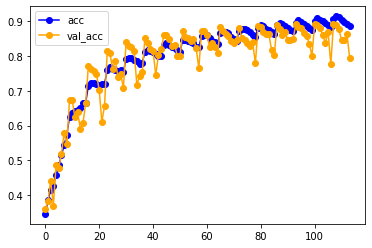

In [24]:
plot_training_progress(csv_file_path = "{fold}log_{ts}.csv".format(fold = config_log_folder, ts = config_model_timestamp),
                       train_metric = 'acc',
                       validation_metric = 'val_acc')

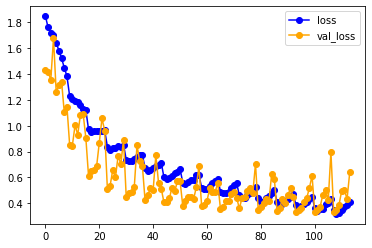

In [25]:
plot_training_progress(csv_file_path = "{fold}log_{ts}.csv".format(fold = config_log_folder, ts = config_model_timestamp),
                       train_metric = 'loss',
                       validation_metric = 'val_loss')

#### Look at several test images and their estimates

In [32]:
test_x_arrays = [resize(np.array(load_img(c)), (config_img_height, config_img_width)) for c in tqdm(test_x)]

100%|██████████████████████████████████████████████████████████████████████████████| 4418/4418 [07:41<00:00,  9.57it/s]


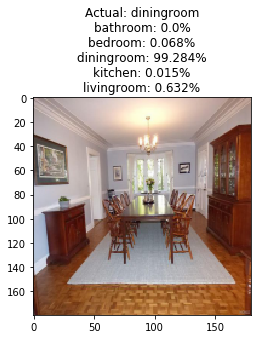

In [37]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

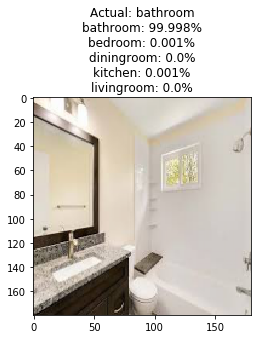

In [38]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

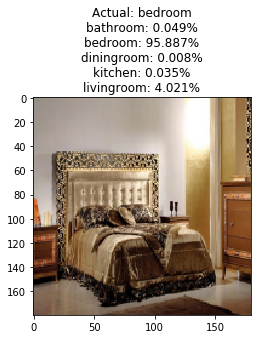

In [39]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

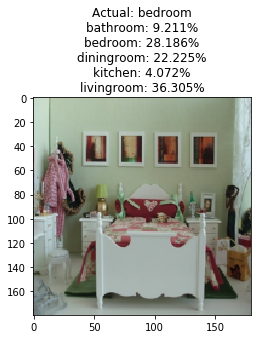

In [40]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

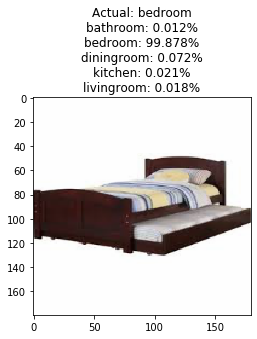

In [41]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

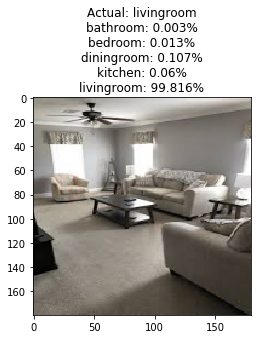

In [42]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

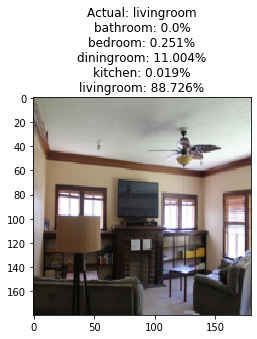

In [43]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

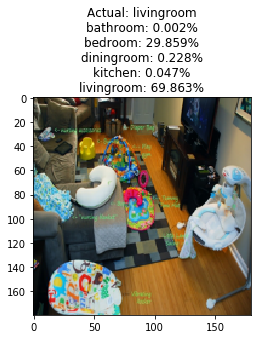

In [44]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

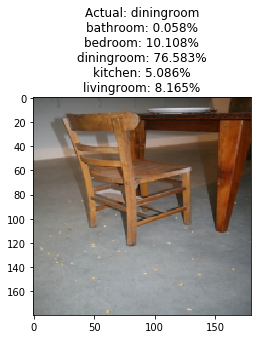

In [45]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

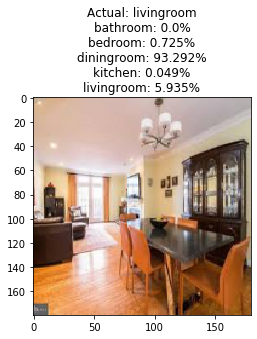

In [46]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

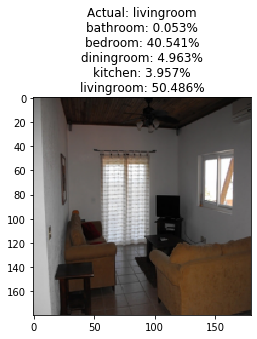

In [47]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

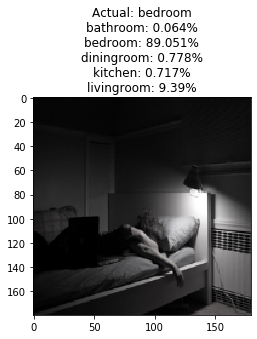

In [48]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

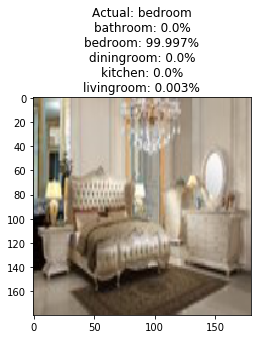

In [49]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

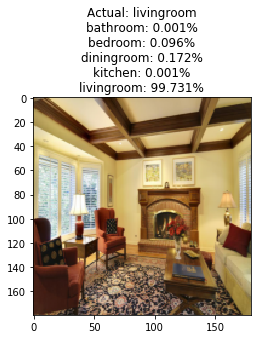

In [50]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

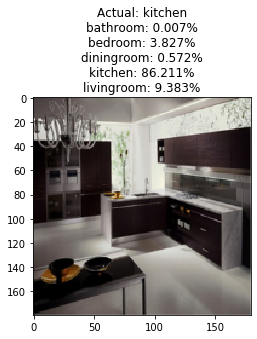

In [51]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

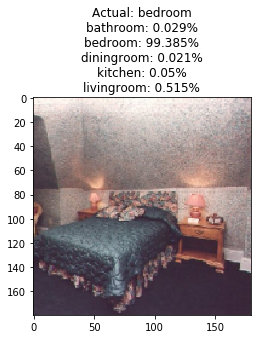

In [52]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

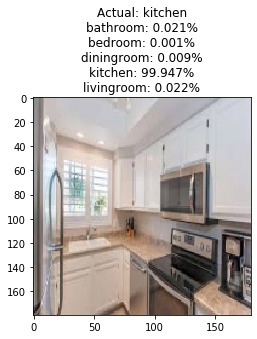

In [53]:
plot_random_test_pred(test_y, probabilities, class_list, test_x_arrays)

In [ ]:
"""

try applying slow start epochs to beginning of every cycle (change learning rate schedule function)

in fit_generator: {use_multiprocessing=True, workers=16}





https://groups.csail.mit.edu/vision/datasets/ADE20K/
http://places.csail.mit.edu/
https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
trulia.com
redfin.com
zillow.com
https://github.com/spmallick/learnopencv/blob/master/downloadOpenImages/downloadOI.py





"""